<div class="alert alert-success h1" role="alert">
    <b>Creant el model!</b>
</div>

In [62]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, LabelBinarizer, OrdinalEncoder
from sklearn.preprocessing import Binarizer
import sklearn.preprocessing as preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [63]:
from sklearn.model_selection import train_test_split

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

<div class="alert alert-success" role="alert">
    <h2>1. Importar el model</h2>
    <p>Utilitzarem el model de titanic i buscarem el millor model!</p><a href='https://www.kaggle.com/competitions/titanic/data?select=test.csv'>Link al Dataset</a>
</div>

In [2]:
df = pd.read_csv('train.csv', index_col='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


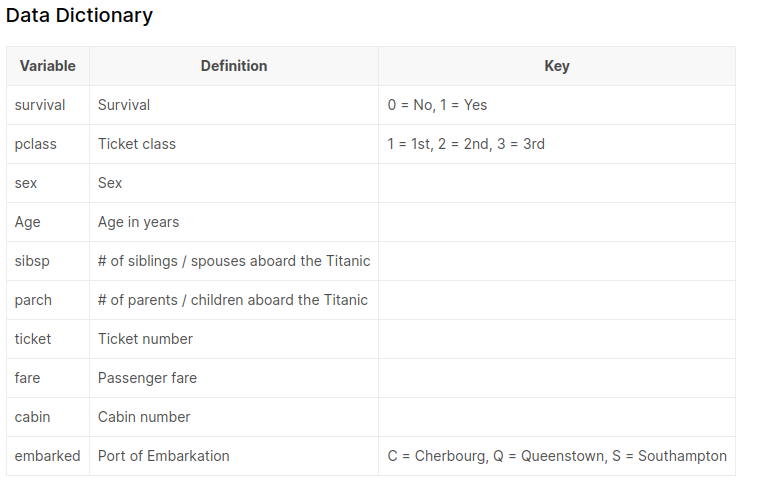

In [3]:
df = df[['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Survived']]

In [4]:
df.isnull().sum()

Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
Survived      0
dtype: int64

In [5]:
df.dtypes

Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
Survived      int64
dtype: object

<div class="alert alert-success h2" role="alert">
    <b>2. Preprocessing</b>
</div>

<Figure size 432x288 with 0 Axes>

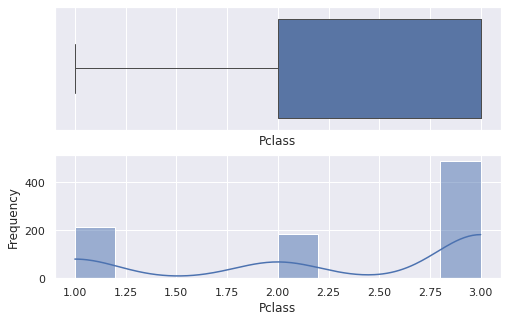

<Figure size 576x360 with 0 Axes>

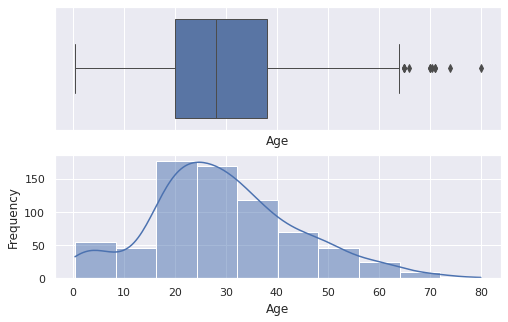

<Figure size 576x360 with 0 Axes>

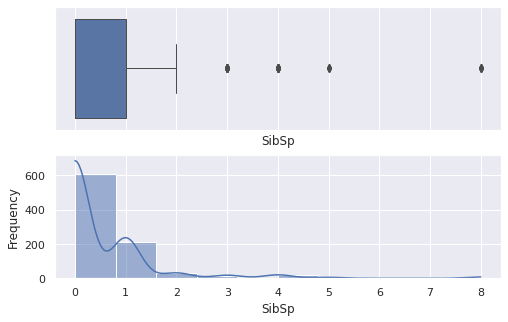

<Figure size 576x360 with 0 Axes>

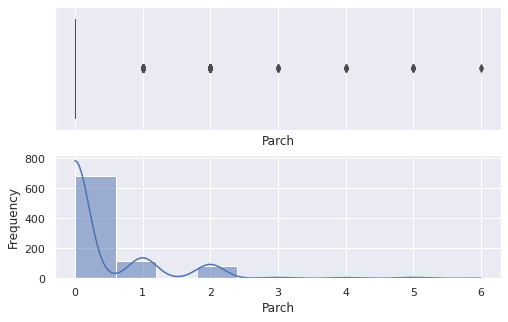

<Figure size 576x360 with 0 Axes>

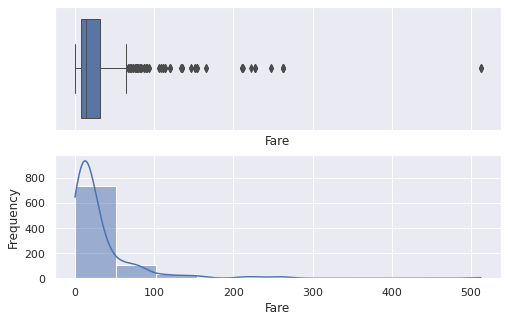

<Figure size 576x360 with 0 Axes>

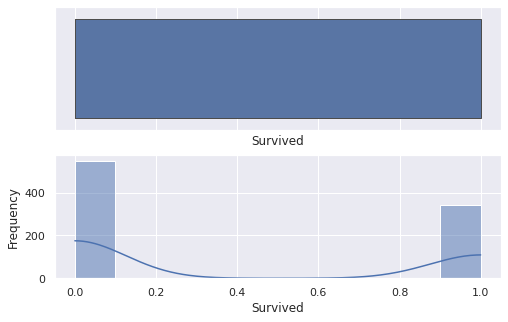

In [6]:
for i in df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']]:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(8, 5)})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Frequency')
    sns.boxplot(df[i],  ax=ax_box , linewidth= 1.0)
    sns.histplot(df[i], ax=ax_hist , bins = 10,kde=True)

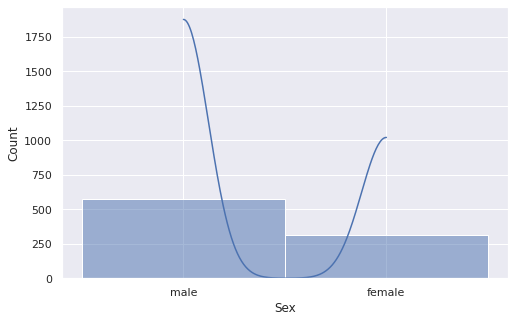

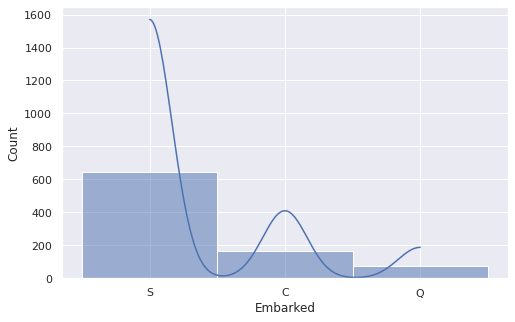

In [7]:
for i in df[['Sex', 'Embarked']]:
    plt.figure()
    sns.histplot(df[i] , bins = 10,kde=True)

<div class="alert alert-warning" role="alert">
    <h3>2.1 Dades numèriques!</h3>
    Aquest serà el més fàcil! Veiem que cap sembla normal, per tant el dividirem entre les que tenen outliers i les que no!
</div>

In [8]:
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
numeric_transformer = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('robust', RobustScaler())
    ]
)

numeric_features_minmax = ['Pclass']
numeric_transformer_minmax = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('minmax', MinMaxScaler())
    ]
)

<div class="alert alert-warning" role="alert">
    <h3>2.2 Dades categòriques!</h3>
    Aqui bineritzarem Sex i utilitzarem OneHotEncoder per Embarked
</div>

In [9]:
categorical_features_bin = ['Sex']
categorical_transformer_bin = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
        ('ordinalEncoder', OrdinalEncoder())
    ]
)

categorical_features = ['Embarked']
categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'most_frequent', fill_value = 'missing')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

<div class="alert alert-warning" role="alert">
    <h3>2.3 Altres tipus de dades!</h3>
    Les dades restant no les podem posar a més categories, en aquest cas el que es pot fer és la creació d'altres preprocessats:
    <a href='https://towardsdatascience.com/customizing-sklearn-pipelines-transformermixin-a54341d8d624'>[1]</a>
    <a href='https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156'>[2]</a>
    <a href='https://www.andrewvillazon.com/custom-scikit-learn-transformers/'>[3]</a>
</div>

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np 

class DateTimeTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.c_[[self.get_title(x) for x in X]]

    def get_title(self, x):
        
        title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

        value_title = 0
        for key, value in title_mapping.items():
            if key in x:
                value_title = value
                continue;
        return value_title

<div class="alert alert-warning" role="alert">
    <h3>Pipeline</h3>
    Una vegada creada totes les pipelines, utilitzem ColumnTransformer per utilitzar a cada una de les variables escollides
</div>

In [11]:
preprocessor = ColumnTransformer(
    [
        ('name', DateTimeTransformer(),'Name'),
        ('categoricals', categorical_transformer, categorical_features),
        ('categorical_bin', categorical_transformer_bin, categorical_features_bin),
        ('numericals', numeric_transformer, numeric_features),
        ('numericals_minmax', numeric_transformer_minmax, numeric_features_minmax)
        
    ],
    remainder = 'drop'
)

<div class="alert alert-success" role="alert">
    <b class="h2">3. Model</b>
    <p>Utilitzarem un nou pipeline, creat a partir del ColumnTransformer, per trobar el millor model!</p>
</div>

In [12]:
X = df.drop('Survived', axis = 1)
y = df.Survived

In [15]:
y.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [47]:
rfc = RandomForestClassifier(random_state = 42)
## Pipeline
pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('model', rfc)
        ])

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
pipeline.fit(X_train, y_train)
print('Accuracy score: {0:.2f}'.format(pipeline.score(X_test, y_test)))

Accuracy score: 0.83


In [25]:
pipeline.predict(X_test)

array([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1])

In [59]:
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('name', DateTimeTransformer(),
                                                  'Name'),
                                                 ('categoricals',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked']),
                                                 ('categorical_bin',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(fill_val...
                                                                                 strategy='constant')),
                                                                  ('ordinalEncoder',
                                                                   OrdinalEncoder())]),
                                                  ['Sex']),
                                                 ('numericals',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('numericals_minmax',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['Pclass'])])),
                ('clf', LogisticRegression())])

<div class="alert alert-warning" role="alert">
    <h1>Exercici 1</h1>
    <p> Troba el millor model i els millor paràmetres!</p>
</div>

In [51]:
## Loop per trobar el millor model

lda = LinearDiscriminantAnalysis()
knc = KNeighborsClassifier()
gnb = GaussianNB()
dtc = DecisionTreeClassifier(random_state = 42)
svc = SVC(random_state = 42)
rfc = RandomForestClassifier(random_state = 42)
lr = LogisticRegression()

In [52]:
evaluation = pd.DataFrame({'model':['lda','knc','gnb','dtc','svc','rfc','lr']})

In [53]:
from sklearn.model_selection import cross_val_score

models = [lda, knc, gnb, dtc, svc, rfc, lr]
score_mean = []
score_std = []

for model in models:
    pipeline = Pipeline(
        [
            ('preprocessing', preprocessor),
            ('model', model)
        ]
    )
    score = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
    score_mean.append(score.mean())
    score_std.append(score.std())

In [54]:
evaluation['f1_cv'] = score_mean
evaluation['f1_std_cv'] = score_std
evaluation

,model,f1_cv,f1_std_cv
0,lda,0.752589,0.036865
1,knc,0.719847,0.024499
2,gnb,0.741490,0.039945
3,dtc,0.714698,0.033996
4,svc,0.756747,0.041868
5,rfc,0.747482,0.044075
6,lr,0.763968,0.044975


In [73]:
pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', LogisticRegression())
    ]
)

params = {
    'model__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky'],
    'model__penalty': ['l1', 'l2', 'elasticnet', None],
    'model__C': [0.01, 0.1, 0.5, 1, 2, 10, 100],
    'model__random_state': [42]
}

rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)

cv = GridSearchCV(pipeline, params, cv = rskf, scoring = ['f1', 'accuracy'], refit = 'f1', n_jobs = -1)



cv.fit(X, y)

print(f'Best F1-score: {cv.best_score_:.3f}\n')
print(f'Best parameter set: {cv.best_params_}\n')
print(f'Scores: {classification_report(y, cv.predict(X))}')

Best F1-score: 0.761

Best parameter set: {'model__C': 0.5, 'model__penalty': 'l2', 'model__random_state': 42, 'model__solver': 'liblinear'}

Scores:               precision    recall  f1-score   support

           0       0.85      0.88      0.86       549
           1       0.80      0.75      0.77       342

    accuracy                           0.83       891
   macro avg       0.82      0.81      0.82       891
weighted avg       0.83      0.83      0.83       891



Accuracy score: 0.82


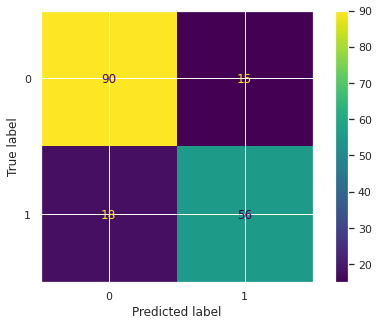

In [82]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', LogisticRegression(C= 0.5, penalty='l2', random_state= 42, solver= 'liblinear'))
    ]
)

pipeline.fit(X_train, y_train)
print('Accuracy score: {0:.2f}'.format(pipeline.score(X_test, y_test)))

y_pred = pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

<div class="alert alert-success" role="alert">
    <b class="h2">4. Millores del model</b>
</div>

In [89]:
from sklearn.metrics import f1_score

pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', LogisticRegression(C= 0.5, penalty='l2', random_state= 42, solver= 'liblinear'))
    ]
)

score = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
print('F1 score: {0:.2f}'.format(score.mean()))

F1 score: 0.77


<div class="alert alert-warning h3" role="alert">PCA
</div>

In [100]:
from sklearn.decomposition import PCA


pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('pca', PCA(n_components = 0.99)),
        ('model', LogisticRegression(C= 0.5, penalty='l2', random_state= 42, solver= 'liblinear'))
    ]
)

score = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
print('F1 score: {0:.2f}'.format(score.mean()))

F1 score: 0.76


<div class="alert alert-warning h3" role="alert">SMOTE <a href='https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html'>Sklearn</a>
</div>

In [103]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', LogisticRegression(C= 0.5, penalty='l2', random_state= 42, solver= 'liblinear'))
    ]
)

score = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
print('F1 score: {0:.2f}'.format(score.mean()))

F1 score: 0.76
